 # **<u> Projet SIGMA M2 : TELEA** </u> 

### **Importation des bibliothèques nécessaire au projet**

In [24]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
import numpy as np
sys.path.insert(0, "/home/onyxia/work/projet_telea_MARTIN_AXEL")
from my_function import rasterisation
from libsigma.read_and_write import load_img_as_array



### **Importation des chemins d'accès**

In [3]:
ts_path = '/home/onyxia/work/data/projet_eval'
result_path = '/home/onyxia/work/projet_telea_MARTIN_AXEL/results/figure'
in_vector = os.path.join(ts_path, "PI_strates_pyrenees_32630.shp")
ref_image = os.path.join(ts_path, "pyrenees_23-24_B02.tif")


### **Importation des échantillons disponibles de la zone d'étude / Analyse des échantillons disponibles** 

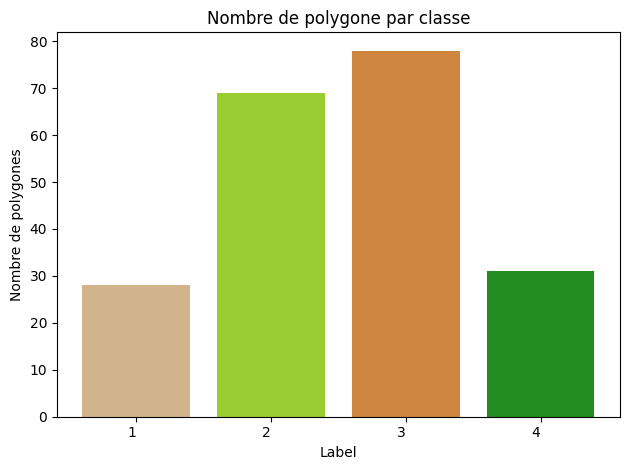

gdal_rasterize -a strate -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/results/samples_raster.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.
Comptage des pixels par classe :
Valeur 1 -> 28 pixels
Valeur 2 -> 75 pixels
Valeur 3 -> 80 pixels
Valeur 4 -> 26 pixels


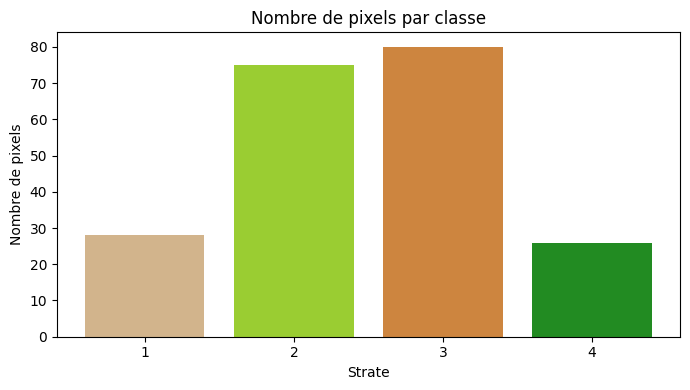

In [35]:
sample_data = gpd.read_file(in_vector)
sample_data.head
counts_label = sample_data.groupby("strate").size()

ref_raster = '/home/onyxia/work/data/projet_eval/pyrenees_23-24_B02.tif'
strat = "strate"
samples_raster = '/home/onyxia/work/results/samples_raster.tif'


colors = ["tan","yellowgreen", "peru", "forestgreen"]
plt.bar(counts_label.index.astype(str), counts_label.values, color=colors)
plt.title("Nombre de polygone par classe")
plt.xticks(ha="right")
plt.xlabel("Label")
plt.ylabel("Nombre de polygones")
plt.tight_layout()
plt.show()

rasterisation(in_vector, ref_image, samples_raster, strat, dtype="Int32")

arr3d = load_img_as_array(samples_raster, verbose=False)

arr = arr3d[:, :, 0]                                      # on prend la bande 1

# enlever le fond (0)
vals = arr[arr != 0]

values, counts = np.unique(vals, return_counts=True)

print("Comptage des pixels par classe :")
for v, c in zip(values, counts):
    print(f"Valeur {int(v)} -> {int(c)} pixels")

# --- 4) Barplot pixels par classe ---
plt.figure(figsize=(7,4))
plt.bar(values.astype(int).astype(str), counts, color=colors[:len(values)])
plt.title("Nombre de pixels par classe")
plt.xlabel("Strate")
plt.ylabel("Nombre de pixels")
plt.tight_layout()
plt.show()